# VAE Analysis

## imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.stats import norm

from models.VAE import VariationalAutoencoder
from utils.loaders import load_mnist, load_model

import pickle

In [3]:
# run params
SECTION = 'vae'
RUN_ID = '0003'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

## data

In [4]:
(x_train, y_train), (x_test, y_test) = load_mnist()

## architecture

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, LeakyReLU, Flatten
from tensorflow.keras.layers import Dense, Conv2DTranspose
from tensorflow.keras.layers import Reshape, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

class Sampling(layers.Layer):
    """Uses (mu, log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        mu, log_var = inputs
        batch = tf.shape(mu)[0]
        dim = tf.shape(mu)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        #epsilon = tf.keras.backend.random_norm
        return mu + tf.exp(log_var/2) * epsilon

z_dim = 2

encoder_input = keras.Input(shape=(28, 28, 1), name='encoder_input')
x = Conv2D(32, 3, strides=1, padding="same", name='encoder_conv_0')(encoder_input)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_1')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=2, padding="same", name='encoder_conv_2')(x)
x = LeakyReLU()(x)
x = Conv2D(64, 3, strides=1, padding="same", name='encoder_conv_3')(x)
x = LeakyReLU()(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)
z = Sampling(name='encoder_output')([mu, log_var])
encoder = keras.Model(encoder_input, [mu, log_var, z], name = 'encoder')

decoder_input = keras.Input(shape=(z_dim,), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(64, 3, strides=1, padding="same", name='decoder_conv_t0')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", name='decoder_conv_t1')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(32, 3, strides=2, padding="same", name='decoder_conv_t2')(x)
x = LeakyReLU()(x)
x = layers.Conv2DTranspose(1, 3, strides=1, padding="same", name='decoder_conv_t3')(x)
decoder_output = Activation('sigmoid')(x)
decoder = keras.Model(decoder_input, decoder_output, name="decoder")

class VAEModel(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAEModel, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        #self.r_loss_factor = r_loss_factor

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            #z_mean, z_log_var, z = self.encoder(data)
            #reconstruction = self.decoder(z)
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                #tf.square(data - reconstruction), axis = [1,2,3]
                keras.losses.binary_crossentropy(data, reconstruction)
            )
            #reconstruction_loss *= r_loss_factor
            reconstruction_loss *= 28 * 28
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_sum(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self,inputs):
        latent = self.encoder(inputs)
        return self.decoder(latent)

save_folder = os.path.join(RUN_FOLDER, 'weights')
#vae = VAEModel(encoder, decoder)

#vae.load_weights(save_folder+'/checkpoint')
vae = keras.models.load_model(save_folder)

In [6]:
vae.summary()

Model: "vae_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Functional)         [(None, 2), (None, 2), (N 105220    
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         102017    
Total params: 207,237
Trainable params: 207,237
Non-trainable params: 0
_________________________________________________________________


## reconstructing original paintings

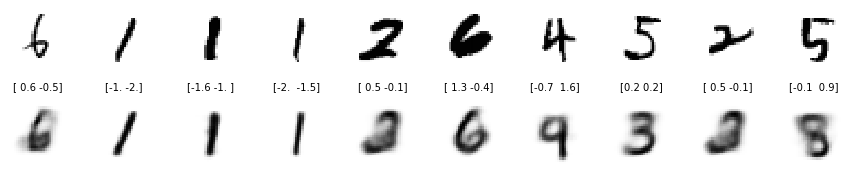

In [7]:
n_to_show = 10
#np.random.seed(0)
example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]

_,_,z_points = vae.encoder.predict(example_images)

reconst_images = vae.decoder.predict(z_points)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')


## Mr N. Coder's wall

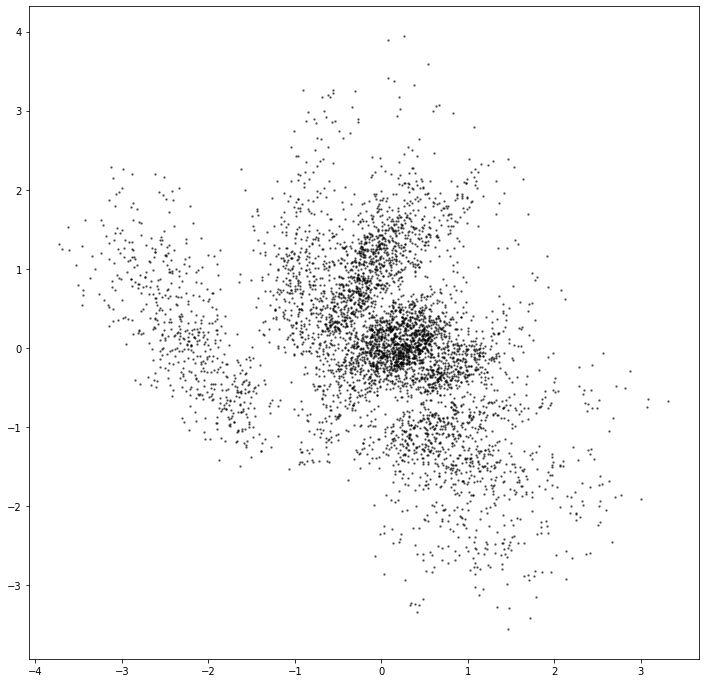

In [9]:
n_to_show = 5000
figsize = 12

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

_,_,z_points = vae.encoder.predict(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

### The new generated art exhibition

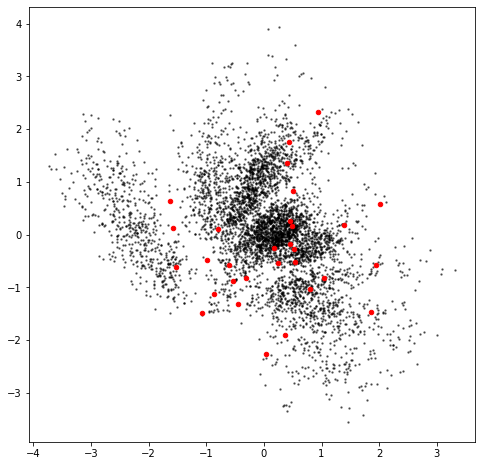

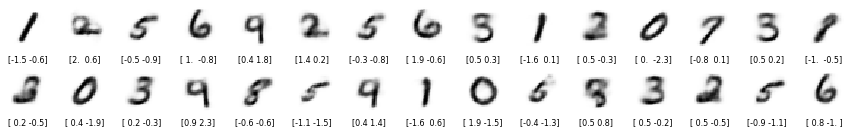

In [10]:
figsize = 8
plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)


grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.normal(size = grid_size * grid_depth)
y = np.random.normal(size = grid_size * grid_depth)

z_grid = np.array(list(zip(x, y)))
reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i],1)), fontsize=8, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

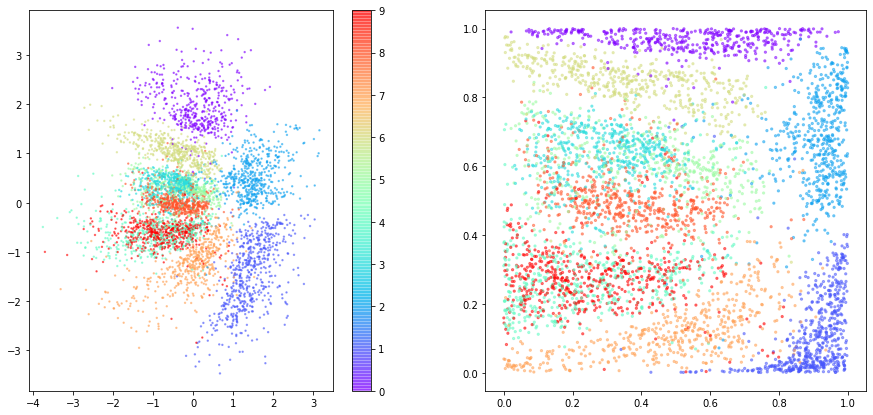

In [11]:
n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

_,_,z_points = vae.encoder.predict(example_images)
p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

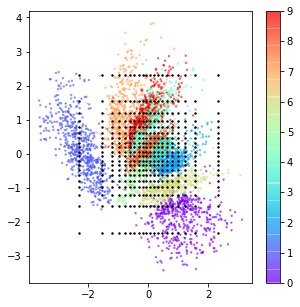

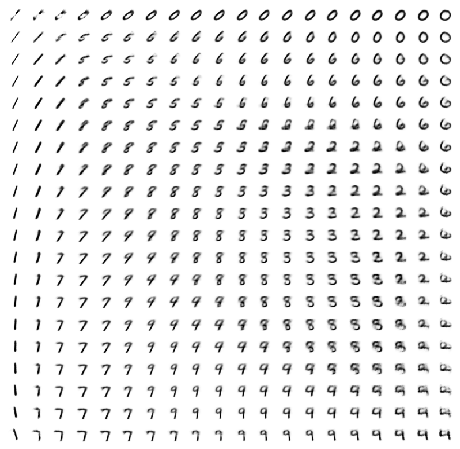

In [11]:
n_to_show = 5000
grid_size = 20
figsize = 8

example_idx = np.random.choice(range(len(x_test)), n_to_show)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]

_,_,z_points = vae.encoder.predict(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

x = norm.ppf(np.linspace(0.01, 0.99, grid_size))
y = norm.ppf(np.linspace(0.01, 0.99, grid_size))
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)))

reconst = vae.decoder.predict(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=2)




plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')